In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [131]:
data1 = pd.read_csv("../data1.csv")
data2 = pd.read_csv("../data2.csv")
data = pd.concat([data1, data2], axis=0).reset_index()
data.head()
print(data.shape, data1.shape, data2.shape)
trueDataCols = ['r' + str(i) for i in range(1, 35)] + ['c1', 'c2'] + ['outside']

(4800, 56) (2400, 55) (2400, 55)


[-0.033125, -0.027916666666666666, -0.02666666666666667, -0.03375]
Bias: -0.030364583333333334
[0.03203440821004376, 0.027142981176634023, 0.02596096408974092, 0.0326177328610127]
Variance: 0.029439021584357853


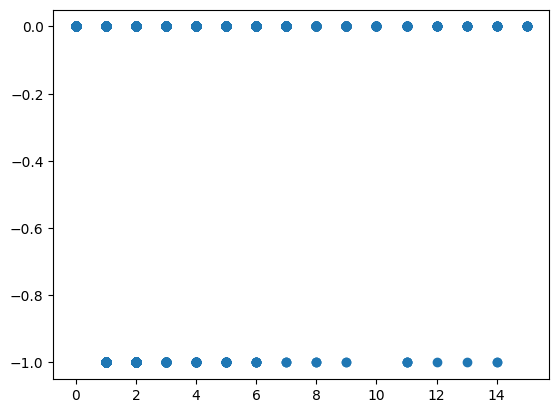

In [148]:
### Investigating the accuracy of the camera sensor
# We are going to assume the camera sensors are i.i.d estimators of the room's occupancy.
# From our initial investigation, they look to have statistically similar bias and variance.

# Camera 1 in room 3
# Camera 2 in room 21
# Camera 3 in room 25
# Camera 4 in room 34
cameras = pd.DataFrame(data[['camera1', 'r3', 'camera2', 'r21', 'camera3', 'r25', 'camera4', 'r34', 'time']])

cameras['err1'] = cameras['camera1'] - cameras['r3']
cameras['err2'] = cameras['camera2'] - cameras['r21']
cameras['err3'] = cameras['camera3'] - cameras['r25']
cameras['err4'] = cameras['camera4'] - cameras['r34']

# Slighly biased towards showing a smaller number
meanErrors = [
    cameras['err1'].mean(),
    cameras['err2'].mean(),
    cameras['err3'].mean(),
    cameras['err4'].mean(),
]
print(meanErrors)
print(f"Bias: {np.mean(meanErrors)}")

varsErrors = [
    cameras['err1'].var(),
    cameras['err2'].var(),
    cameras['err3'].var(),
    cameras['err4'].var(),
]
# Variance is fairly low.
print(varsErrors)
print(f"Variance: {np.mean(varsErrors)}")

### Question - is variance dependent on room occupancy size?
# Again, assuming that cameras are i.i.d. Join all of them into a thingo
# From the plot, doesn't look like these are correlated.
sizes = pd.Series(list(cameras['r3']) + list(cameras['r21']) + list(cameras['r25']) + list(cameras['r34']))
errors = pd.Series(list(cameras['err1']) + list(cameras['err2']) + list(cameras['err3']) + list(cameras['err4']))
sizesVsErrors = pd.DataFrame({"roomSize": sizes, "errors": errors})
plt.scatter(sizesVsErrors['roomSize'], sizesVsErrors['errors']);

[0.0, 0.0]
Bias: 0.0
[0.0, 0.0]
Variance: 0.0


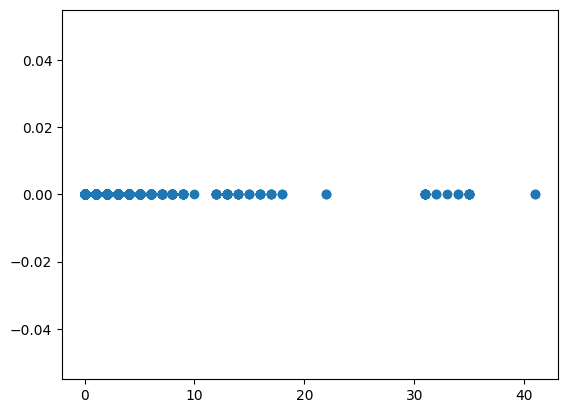

In [147]:
### Investigating the accuracy of the robot sensors
robots = pd.DataFrame(data[['robot1', 'robot2']])
robots['robot1'] = robots['robot1'].apply(ast.literal_eval)
robots['robot2'] = robots['robot2'].apply(ast.literal_eval)
robots['room1'], robots['observed1'] = zip(*robots['robot1'])
robots['room2'], robots['observed2'] = zip(*robots['robot2'])

robots['truth1'] = robots['observed1']
robots['truth2'] = robots['observed2']

# truth1, truth2 = {}, {}
# for K, V in robots['room1'].to_dict().items():
#     truth1[K] = data.iloc[K, data.columns.get_loc(str(V))]
# for K, V in robots['room2'].to_dict().items():
#     truth2[K] = data.iloc[K, data.columns.get_loc(str(V))]

for idx, row in robots.iterrows():
    truth1_room = row['room1']
    truth2_room = row['room2']
    robots.iloc[idx, robots.columns.get_loc("truth1")] = data.iloc[idx, data.columns.get_loc(truth1_room)]
    augh = data.iloc[idx, data.columns.get_loc(truth1_room)]
    robots.iloc[idx, robots.columns.get_loc("truth2")] = data.iloc[idx, data.columns.get_loc(truth2_room)]

robots['err1'] = robots['observed1'] - robots['truth1']
robots['err2'] = robots['observed2'] - robots['truth2']

# Slighly biased towards showing a smaller number
meanErrors = [
    robots['err1'].mean(),
    robots['err2'].mean(),
]
print(meanErrors)
print(f"Bias: {np.mean(meanErrors)}")

varsErrors = [
    robots['err1'].var(),
    robots['err2'].var(),
]
print(varsErrors)
print(f"Variance: {np.mean(varsErrors)}")

### Question - is variance dependent on room occupancy size?
# Again, assuming that cameras are i.i.d. Join all of them into a thingo
# From the plot, doesn't look like these are correlated.
sizes = pd.Series(list(robots['truth1']) + list(robots['truth2']))
errors = pd.Series(list(robots['err1']) + list(robots['err2']))
sizesVsErrors = pd.DataFrame({"roomSize": sizes, "errors": errors})
plt.scatter(sizesVsErrors['roomSize'], sizesVsErrors['errors']);

In [165]:
### Investigating reliability of motion sensors:
# Again, going to assume these behave identically.

# m1 in r1
# m2 in r14
# m3 in r19
# m4 in r28
# m5 in r29
# m6 in r32
motions = pd.DataFrame(data[['motion_sensor1', 'r1', 'motion_sensor2', 'r14', 'motion_sensor3', 'r19', 'motion_sensor4', 'r28', 'motion_sensor5', 'r29', 'motion_sensor6', 'r32']])

motions['motion_sensor1'] = motions['motion_sensor1'] == 'motion'
motions['motion_sensor2'] = motions['motion_sensor2'] == 'motion'
motions['motion_sensor3'] = motions['motion_sensor3'] == 'motion'
motions['motion_sensor4'] = motions['motion_sensor4'] == 'motion'
motions['motion_sensor5'] = motions['motion_sensor5'] == 'motion'
motions['motion_sensor6'] = motions['motion_sensor6'] == 'motion'

motions['p1'] = motions['r1'] > 0
motions['p2'] = motions['r14'] > 0
motions['p3'] = motions['r19'] > 0
motions['p4'] = motions['r28'] > 0
motions['p5'] = motions['r29'] > 0
motions['p6'] = motions['r32'] > 0

cm1 = {
    'tp': (motions['p1'] & motions['motion_sensor1']).sum(), 
    'fp': (~motions['p1'] & motions['motion_sensor1']).sum(), 
    'tn': (~motions['p1'] & ~motions['motion_sensor1']).sum(), 
    'fn': (motions['p1'] & ~motions['motion_sensor1']).sum(),
}

cm2 = {
    'tp': (motions['p2'] & motions['motion_sensor2']).sum(), 
    'fp': (~motions['p2'] & motions['motion_sensor2']).sum(), 
    'tn': (~motions['p2'] & ~motions['motion_sensor2']).sum(), 
    'fn': (motions['p2'] & ~motions['motion_sensor2']).sum(),
}

cm3 = {
    'tp': (motions['p3'] & motions['motion_sensor3']).sum(), 
    'fp': (~motions['p3'] & motions['motion_sensor3']).sum(), 
    'tn': (~motions['p3'] & ~motions['motion_sensor3']).sum(), 
    'fn': (motions['p3'] & ~motions['motion_sensor3']).sum(),
}

cm4 = {
    'tp': (motions['p4'] & motions['motion_sensor4']).sum(), 
    'fp': (~motions['p4'] & motions['motion_sensor4']).sum(), 
    'tn': (~motions['p4'] & ~motions['motion_sensor4']).sum(), 
    'fn': (motions['p4'] & ~motions['motion_sensor4']).sum(),
}

cm5 = {
    'tp': (motions['p5'] & motions['motion_sensor5']).sum(), 
    'fp': (~motions['p5'] & motions['motion_sensor5']).sum(), 
    'tn': (~motions['p5'] & ~motions['motion_sensor5']).sum(), 
    'fn': (motions['p5'] & ~motions['motion_sensor5']).sum(),
}

cm6 = {
    'tp': (motions['p6'] & motions['motion_sensor6']).sum(), 
    'fp': (~motions['p6'] & motions['motion_sensor6']).sum(), 
    'tn': (~motions['p6'] & ~motions['motion_sensor6']).sum(), 
    'fn': (motions['p6'] & ~motions['motion_sensor6']).sum(),
}

for cm in [cm1, cm2, cm3, cm4, cm5, cm6]:
    print("For sensor:")
    # How much does saying 'no motion' indicate no people?
    print(f"True negative rate: {cm['tn'] / (cm['tn'] + cm['fn'])}")

    # How much does saying 'motion' indicate yes people?
    print(f"True positive rate: {cm['tp'] / (cm['tp'] + cm['fp'])}")

motions.head()

For sensor:
True negative rate: 0.8558736426456071
True positive rate: 0.958806443094798
For sensor:
True negative rate: 0.9629384513567174
True positive rate: 0.7350956130483689
For sensor:
True negative rate: 0.9403268719118206
True positive rate: 0.8543107422775472
For sensor:
True negative rate: 0.9908568443051202
True positive rate: 0.4537037037037037
For sensor:
True negative rate: 0.9412521440823327
True positive rate: 0.8804700162074555
For sensor:
True negative rate: 0.9214285714285714
True positive rate: 0.9741463414634146


,motion_sensor1,r1,motion_sensor2,r14,motion_sensor3,r19,motion_sensor4,r28,motion_sensor5,r29,motion_sensor6,r32,p1,p2,p3,p4,p5,p6
0,False,0,False,0,False,0,False,0,True,0,True,0,False,False,False,False,False,False
1,False,0,True,1,False,0,False,0,True,0,False,0,False,True,False,False,False,False
2,False,0,False,0,False,0,True,0,False,0,False,0,False,False,False,False,False,False
3,False,0,True,1,False,0,False,0,False,0,False,0,False,True,False,False,False,False
4,False,0,True,1,False,0,False,0,False,0,False,0,False,True,False,False,False,False
